Loading data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from model.MLP_enzymes import MLP_enzymes
from model.random_forest_enzymes import random_forest_enzymes
from utils.evaluation_metrics import evaluation_metrics
from utils.get_features import get_features
from utils.load_fasta import load_fasta
from utils.split_test_train import split_test_train
from utils.train_mlp import train_mlp

# Path to FASTA files
enzyme_path = 'data/enzyme/enzyme.fasta'
not_enzyme_path = 'data/not_enzyme/not_enzyme.fasta'

# Load FASTA files to Seq
enzyme, not_enzyme = load_fasta(enzyme_path, not_enzyme_path)

# Create features of every sequence
enzyme_features = get_features(enzyme)
not_enzyme_features = get_features(not_enzyme)

difference = pd.DataFrame()
columns = []
values = []
for column in enzyme_features:
    columns.append(column)
    diff = abs((enzyme_features[column].mean() - not_enzyme_features[column].mean()))
    sum = (abs(enzyme_features[column]) + abs(not_enzyme_features[column])).mean()
    value_tt = abs(diff / sum) 
    values.append(value_tt) 

difference['columns'] = columns
difference['values'] = values
difference = difference.sort_values(by=['values'])
print(difference.head(25))

# Split data into train and test sets
x_train, x_test, y_train, y_test = split_test_train(enzyme_features, not_enzyme_features)

   columns    values
2        E  0.032969
9        R  0.036764
4        G  0.037989
12       W  0.038353
3        F  0.041618
1        D  0.057961
5        H  0.061430
13       Y  0.063503
7        P  0.066327
11       V  0.067040
0        C  0.069944
6        I  0.099529
10       S  0.104152
8        Q  0.108084
14   gravy  0.201689


Random Forest

In [3]:
# Create random forest model
model_random_forest = random_forest_enzymes(x_train, y_train)

# Predictions of random forest model
y_predict_rf = model_random_forest.predict(x_test)

# Calculate evaluation metrics of rf model
accuracy_rf, f1_rf, conf_matrix_rf = evaluation_metrics(y_test, y_predict_rf)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s


KeyboardInterrupt: 

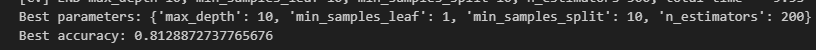

MLP

15
Epoch 20/1000, Loss 0.5281
Epoch 40/1000, Loss 0.4765
Epoch 60/1000, Loss 0.4612
Epoch 80/1000, Loss 0.4520
Epoch 100/1000, Loss 0.4470
Epoch 120/1000, Loss 0.4368
Epoch 140/1000, Loss 0.4297
Epoch 160/1000, Loss 0.4236
Epoch 180/1000, Loss 0.4209
Epoch 200/1000, Loss 0.4145
Epoch 220/1000, Loss 0.4104
Epoch 240/1000, Loss 0.4085
Epoch 260/1000, Loss 0.4055
Epoch 280/1000, Loss 0.4028
Epoch 300/1000, Loss 0.4005
Epoch 320/1000, Loss 0.3996
Epoch 340/1000, Loss 0.3973
Epoch 360/1000, Loss 0.3955
Epoch 380/1000, Loss 0.3937
Epoch 400/1000, Loss 0.3917
Epoch 420/1000, Loss 0.3898
Epoch 440/1000, Loss 0.3908
Epoch 460/1000, Loss 0.3877
Epoch 480/1000, Loss 0.3840
Epoch 500/1000, Loss 0.3850
Epoch 520/1000, Loss 0.3833
Epoch 540/1000, Loss 0.3804
Epoch 560/1000, Loss 0.3780
Epoch 580/1000, Loss 0.3759
Epoch 600/1000, Loss 0.3748
Epoch 620/1000, Loss 0.3750
Epoch 640/1000, Loss 0.3735
Epoch 660/1000, Loss 0.3722
Epoch 680/1000, Loss 0.3722
Epoch 700/1000, Loss 0.3760
Epoch 720/1000, Loss 

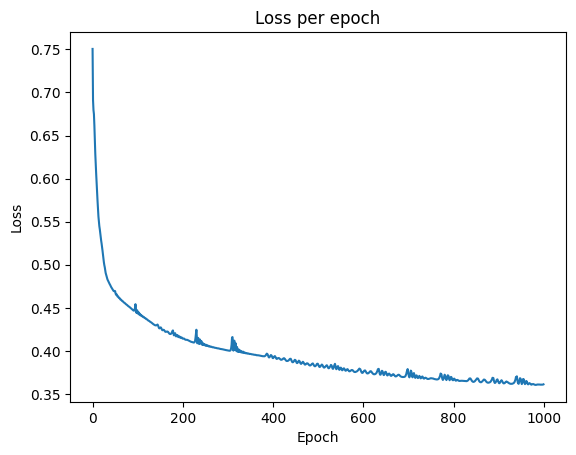

In [10]:
# Transform data sets into tensors
x_test_tensor = torch.tensor(x_test.to_numpy(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long)
x_train_tensor = torch.tensor(x_train.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long)

# Create MLP model
input_len = len(x_test_tensor[1])
print(input_len)
model_MLP = MLP_enzymes(input_len)

# Train model
train_mlp(model_MLP, x_train_tensor, y_train_tensor)

# Set model to evaluate
model_MLP.eval()

# Get predicted value
with torch.no_grad():
    y_predict_MLP = model_MLP(x_test_tensor)

    _, predicted_classes_MLP = torch.max(y_predict_MLP, 1)

# Transform predicted values to numpy
predicted_classes_MLP_npy = predicted_classes_MLP.cpu().numpy()

# Get evaluation metrics of MLP model
accuracy_MLP, f1_MLP, conf_matrix_MLP = evaluation_metrics(y_test, predicted_classes_MLP_npy)

Results

---------- RANDOM FOREST ----------
Accuracy 0.8260
F1 Score 0.8339
[[1255  357]
 [ 204 1408]]
---------- MLP ----------
Accuracy 0.8213
F1 Score 0.8285
[[1257  355]
 [ 221 1391]]


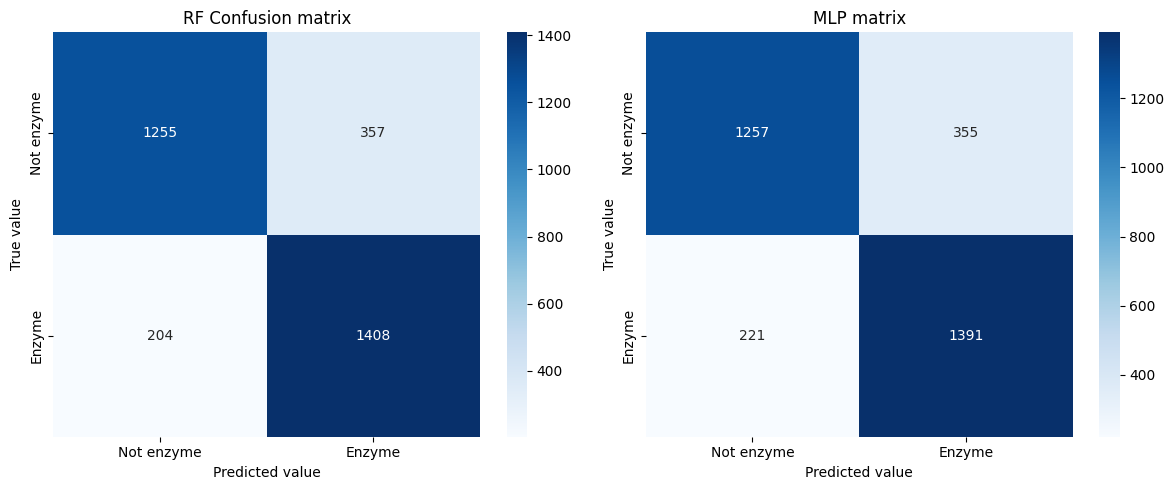

In [11]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Print evaluation metrics of RF
print("---------- RANDOM FOREST ----------")
print(f"Accuracy {accuracy_rf:.4f}")
print(f"F1 Score {f1_rf:.4f}")
print(f"{conf_matrix_rf}")

# Create RF heatmap of conf_matrix
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not enzyme', 'Enzyme'], yticklabels=['Not enzyme', 'Enzyme'],
            ax=axes[0])
axes[0].set_title('RF Confusion matrix')
axes[0].set_ylabel('True value')
axes[0].set_xlabel('Predicted value')

# Print evaluation metrics of MLP
print("---------- MLP ----------")
print(f"Accuracy {accuracy_MLP:.4f}")
print(f"F1 Score {f1_MLP:.4f}")
print(f"{conf_matrix_MLP}")

# Create MLP heatmap of conf_matrix
sns.heatmap(conf_matrix_MLP, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not enzyme', 'Enzyme'], yticklabels=['Not enzyme', 'Enzyme'],
            ax=axes[1])
axes[1].set_title('MLP matrix')
axes[1].set_ylabel('True value')
axes[1].set_xlabel('Predicted value')

# Print heatmaps
plt.tight_layout()
plt.show()